In [9]:
## !pip install -q datasets jiwer
## !pip install -q transformers

import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import VisionEncoderDecoderModel

In [1]:
model = VisionEncoderDecoderModel.from_pretrained("team-lucid/trocr-small-korean")

pixel_values = torch.rand(1, 3, 384, 384)
generated_ids = model.generate(pixel_values)

C:\Users\wjdgh\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\wjdgh\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\wjdgh\anaconda3\lib\site-packages\transformers\generation\utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [7]:
df = pd.read_csv("C:/Users/wjdgh/Desktop/Recognition_Data/Training/Labels_sample/info.csv",encoding='cp949')

In [61]:
df.head(50)

file_name   text
0    EDU_E1_038049_1.jpg    안에서
1    EDU_E1_038049_2.jpg   있었지만
2    EDU_E1_038049_3.jpg   흔들렸다
3    EDU_E1_038049_4.jpg     흔들
4    EDU_E1_038049_5.jpg     나는
5    EDU_E1_038049_6.jpg     안전
6    EDU_E1_038049_7.jpg  행복버스를
7    EDU_E1_038049_8.jpg     탔다
8    EDU_E1_038049_9.jpg     버스
9   EDU_E1_038049_10.jpg     교통
10  EDU_E1_038049_11.jpg     지진
11  EDU_E1_038049_12.jpg     화재
12  EDU_E1_038049_13.jpg     체험
13  EDU_E1_038049_14.jpg      을
14  EDU_E1_038049_15.jpg     했다
15  EDU_E1_038049_16.jpg     차가
16  EDU_E1_038049_17.jpg     멈춰
17  EDU_E1_038049_20.jpg    실제로
18  EDU_E1_038049_21.jpg    움직이
19  EDU_E1_038049_22.jpg      는
20  EDU_E1_038049_23.jpg    것처럼
21  EDU_E1_038049_24.jpg    의자가
22  EDU_E1_038049_25.jpg  안전벨트를
23  EDU_E1_038049_26.jpg    했더니
24  EDU_E1_038049_27.jpg    다치지
25  EDU_E1_038049_28.jpg      않
26  EDU_E1_038049_29.jpg     았다
27  EDU_E1_038049_30.jpg    지진이
28  EDU_E1_038049_31.jpg      난
29  EDU_E1_038049_32.jpg    것처럼
30  EDU_E1_038049_33.jpg     버스
31  EDU_E1_038049_34.jpg    바닥이
32   EDU_E1_038205_1.jpg     근데
33   EDU_E1_038205_2.jpg     돈을
34   EDU_E1_038205_3.jpg      4
35   EDU_E1_038205_4.jpg     만원
36   EDU_E1_038205_5.jpg      밖
37   EDU_E1_038205_6.jpg      안
38   EDU_E1_038205_7.jpg    가지고
39   EDU_E1_038205_8.jpg    왔다.
40   EDU_E1_038205_9.jpg     그@
41  EDU_E1_038205_10.jpg    엄마가
42  EDU_E1_038205_11.jpg      꼭
43  EDU_E1_038205_12.jpg    막사지
44  EDU_E1_038205_14.jpg     진짜
45  EDU_E1_038205_15.jpg  필요한것만
46  EDU_E1_038205_16.jpg      사
47  EDU_E1_038205_17.jpg      라
48  EDU_E1_038205_18.jpg   하셨다.
49  EDU_E1_038205_19.jpg    그@서

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class HandWriting(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [16]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = HandWriting(root_dir='C:/Users/wjdgh/Desktop/Recognition_Data/Training/Images_sample/',
                           df=train_df,
                           processor=processor)
eval_dataset = HandWriting(root_dir='C:/Users/wjdgh/Desktop/Recognition_Data/Training/Images_sample/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [14]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 221
Number of validation examples: 56


In [62]:
encoding = train_dataset[20]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


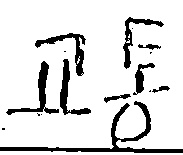

In [63]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][20]).convert("RGB")
image

In [64]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

교통


In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [23]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [24]:
from datasets import load_metric

cer_metric = load_metric("cer")

C:\Users\wjdgh\AppData\Local\Temp\ipykernel_39920\152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [25]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [26]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

C:\Users\wjdgh\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/56 [00:00<?, ?it/s]

KeyboardInterrupt: 